In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

## 1. Camera Calibration

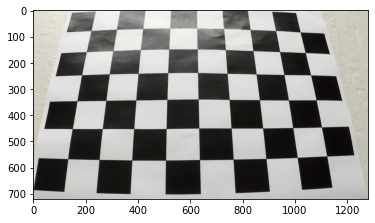

In [2]:
image = mpimg.imread("camera_cal/calibration3.jpg")
plt.imshow(image)

In [3]:
def get_ChessBoardCorners(gray_img , points_x, points_y):     
    objpoints =[]
    imgpoints = []
    objp = np.zeros((points_x*points_y,3), np.float32)
    objp[:,:2] = np.mgrid[0:points_x, 0:points_y].T.reshape(-1,2)
    
    ret, corners = cv2.findChessboardCorners(gray_img, (points_x, points_y), None)
    # If found, output corners
    if ret == False:
        print("Incorrect default corner numbers, try again. ")
    else:        
        objpoints.append(objp)
        imgpoints.append(corners) 
                
        return  objpoints, imgpoints 

def ChessBoard_Undistort(img, points_x, points_y):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    objpoints, imgpoints = get_ChessBoardCorners(gray , points_x, points_y)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Use cv2.calibrateCamera() and cv2.undistort()
    #undist = np.copy(img)  # Delete this line
    return dst, mtx, dist

def draw_Corners(img,nx,ny):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        output = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        return output
    else:
        print(" ret == Flase")



#### Output of camera calibration

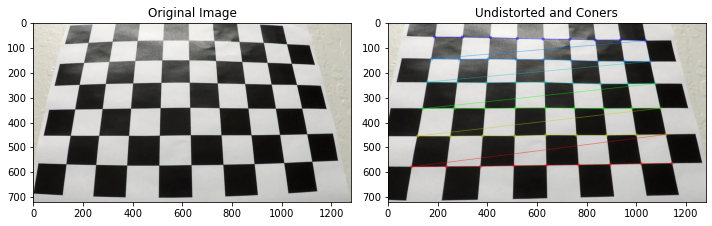

In [4]:
image = mpimg.imread("camera_cal/calibration3.jpg")
undistort, mtx, dist = ChessBoard_Undistort(image, 9,6) 
copy = np.copy(undistort)
witn_corners = draw_Corners(copy,9,6)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image)
ax1.set_title('Original Image')
ax2.imshow(witn_corners)
ax2.set_title('Undistorted and Coners')
plt.tight_layout()

In [6]:
print(mtx)

[[1.36430866e+03 0.00000000e+00 6.97740984e+02]
 [0.00000000e+00 1.37926336e+03 3.44696483e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


## 2. Image Processing RGB to Binary

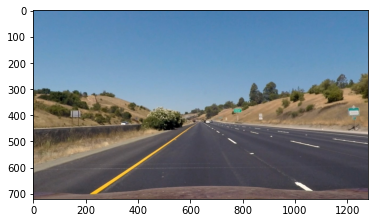

In [5]:
image = mpimg.imread("test_images/straight_lines1.jpg")
image = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(image)

### 2.1 Sobel

In [6]:
def Sobel_raw_x_y_output(img , sobel_kernel = 3):
    gray = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
    sobel_raw_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobel_raw_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    return sobel_raw_x, sobel_raw_y

def Sobel_Absolute_Binary(sobel , low_thresh, high_thresh, img_output = False):
    abs_sobel = np.absolute(sobel)
    scal_factor = 255/np.max(abs_sobel)
    scaled_sobel = np.uint8(abs_sobel*scal_factor)    
    thres = ((scaled_sobel >= low_thresh) & (scaled_sobel <= high_thresh))
    scaled_sobel[~thres] = 0    
    binary = np.uint8(np.zeros_like(sobel))
    binary[thres] = 1
    
    if img_output == True:
        plt.imshow(scaled_sobel, cmap='gray')    
        
    return binary

def Sobel_Magnitude_Binary(sobel_raw_x, sobel_raw_y,low_thresh, high_thresh, img_output = False):
    magnitude_sobel = np.sqrt((sobel_raw_x)**2+(sobel_raw_y)**2)
    scal_factor = 255/np.max(magnitude_sobel)
    scaled_sobel = np.uint8(magnitude_sobel*scal_factor)    
    thres = ((scaled_sobel >= low_thresh) & (scaled_sobel <= high_thresh))
    scaled_sobel[~thres] = 0    
    binary = np.zeros_like(sobel_raw_x)
    binary[thres] = 1
    
    if img_output == True:
        plt.imshow(scaled_sobel, cmap='gray')    
        
    return binary

def Sobel_Dir_Binary (sobel_raw_x, sobel_raw_y,low_thresh, high_thresh, img_output = False):
    direction_Abs = np.arctan2(np.absolute(sobel_raw_x), np.absolute(sobel_raw_y))
    rad_low_thresh = low_thresh/180 *np.pi
    rad_high_thresh = high_thresh/180 *np.pi
    thres = ((direction_Abs > rad_low_thresh) & (direction_Abs <= rad_high_thresh))
    direction_Abs[~thres] = 0 
    
    if img_output == True:
        plt.imshow(direction_Abs, cmap='gray')
    binary = np.zeros_like(sobel_raw_x)
    binary[thres] = 1      
        
    return binary
    

#### 2.1.1 Sobel Function test 

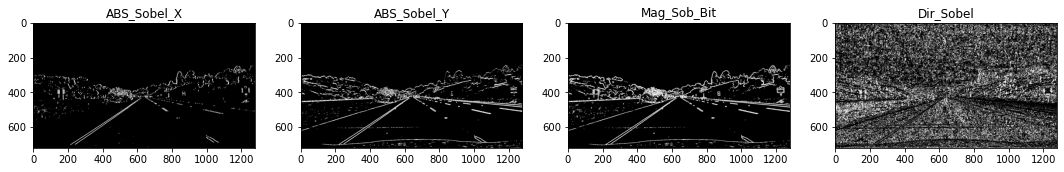

In [7]:
raw_sobel_x, raw_sobel_y = Sobel_raw_x_y_output(image)
Abs_Sob_Bit_Thr_x = Sobel_Absolute_Binary(raw_sobel_x, 30, 255)
Abs_Sob_Bit_Thr_y = Sobel_Absolute_Binary(raw_sobel_y, 30, 255)
Mag_Sob_Bit = Sobel_Magnitude_Binary(raw_sobel_x, raw_sobel_y, 30, 255)
Dir_Sobel_Bit = Sobel_Dir_Binary(raw_sobel_x, raw_sobel_y, 50, 90)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 15))
ax1.imshow(Abs_Sob_Bit_Thr_x , cmap = 'gray')
ax1.set_title('ABS_Sobel_X')
ax2.imshow(Abs_Sob_Bit_Thr_y , cmap = 'gray')
ax2.set_title('ABS_Sobel_Y')
ax3.imshow(Mag_Sob_Bit , cmap = 'gray')
ax3.set_title('Mag_Sob_Bit')
ax4.imshow(Dir_Sobel_Bit , cmap = 'gray')
ax4.set_title('Dir_Sobel')
plt.tight_layout()

### 2.2 HLS color space

In [8]:
def Show_HLS_channel(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_chanel = hls[:,:,0]
    l_chanel = hls[:,:,1]
    s_chanel = hls[:,:,2]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 12))
    ax1.imshow(h_chanel, cmap ='gray')
    ax1.set_title('h_chanel')
    ax2.imshow(l_chanel, cmap ='gray')
    ax2.set_title('l_chanel')
    ax3.imshow(s_chanel, cmap ='gray')
    ax3.set_title('s_chanel')
    plt.tight_layout()
    
def S_Channel_Thresh (img, low_thresh = 180, high_thresh = 255, img_output = False):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_chanel = hls[:,:,2]    
    thres = ((s_chanel >= low_thresh) & (s_chanel <= high_thresh))
    s_chanel[~thres] = 0   
    binary = np.zeros_like(s_chanel)
    binary[thres] = 1
    
    if img_output == True:
        plt.imshow(s_chanel, cmap='gray')
    
    return binary
    

#### 2.2.1 HLS Function test 

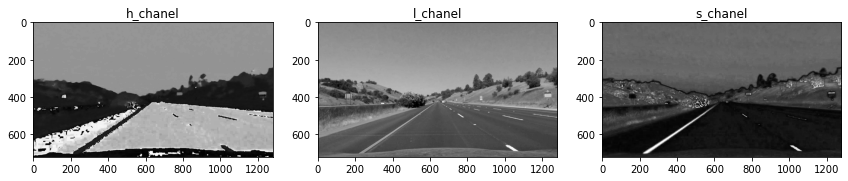

In [9]:
Show_HLS_channel(image)

#### 2.2.2 HLS S Channel Threshold Output

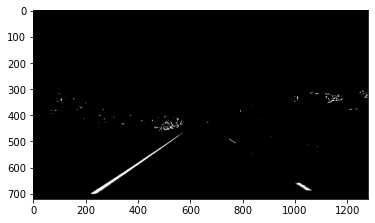

In [10]:
S_HLS_Binary = S_Channel_Thresh(image)
plt.imshow(S_HLS_Binary, cmap = 'gray')

## 3. Get Image Transformation Matrix

In [11]:
def Get_Source_Points(Binary_image, mask_points, top_y_coornate):
    """Target of this function is to get two points for calculation 
       transformantion matrix, mask_points must be carefully selected,
       keep merely interestred region"""
    
    min_line_len = 30
    max_line_gap = 100
    
    height = Binary_image.shape[0]
    
    mask = np.zeros_like(Binary_image)
    cv2.fillPoly(mask, mask_points, 1)
    masked_image = cv2.bitwise_and(Binary_image, mask)

    lines = cv2.HoughLinesP(masked_image, 1, np.pi/180, 15, np.array([]), min_line_len, max_line_gap)
    length_list = []
    slope_list = []
    intersect_bottom = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            slope_list.append(slope)
            length_list.append(np.sqrt((x1-x2)**2 + (y1-y2)**2))
            intersect_bottom.append((height-y2)/slope +x2)
            
    avg_slope = np.dot(slope_list , length_list )/np.sum(length_list)
    avg_intersect_bot = int(np.dot(intersect_bottom, length_list)/np.sum(length_list))
    top_intersect = int((top_y_coornate-height)/avg_slope + avg_intersect_bot)
    
    return (avg_intersect_bot, height) , (top_intersect, top_y_coornate)
 
def show_mask_region(Binary_image, mask_points):
    mask = np.zeros_like(Binary_image)
    cv2.fillPoly(mask, mask_points, 1)
    masked_image = cv2.bitwise_and(Binary_image, mask)
    plt.imshow(masked_image, cmap='gray')

### 3.1 Select Binary Image for Calculating Transformation Matrix

'As shown below, Abs_Sob_Bit_Thr_x has clear line feature, it is more convenient to get\n   nice point as source point'

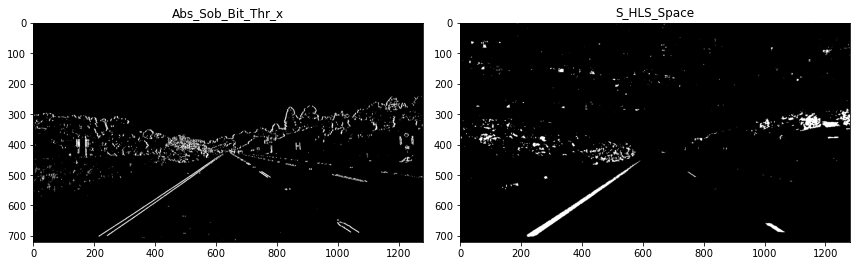

In [12]:
image = mpimg.imread("test_images/straight_lines1.jpg")
image = cv2.undistort(image, mtx, dist, None, mtx)
raw_sobel_x, raw_sobel_y = Sobel_raw_x_y_output(image)
Abs_Sob_Bit_Thr_x = Sobel_Absolute_Binary(raw_sobel_x, 30, 255)
S_HLS_Space = S_Channel_Thresh(image, 110, 255)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(Abs_Sob_Bit_Thr_x, cmap ='gray')
ax1.set_title('Abs_Sob_Bit_Thr_x')
ax2.imshow(S_HLS_Space, cmap ='gray')
ax2.set_title('S_HLS_Space')
plt.tight_layout()

"""As shown below, Abs_Sob_Bit_Thr_x has clear line feature, it is more convenient to get
   nice point as source point"""

### 3.2 Region of Interest

#### 3.2.1 Left Side ROI

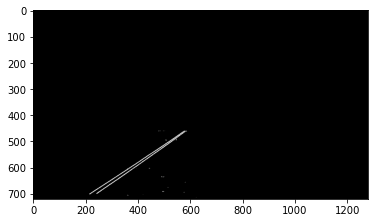

In [13]:
mask_top_cordinate = 460
region_1 = np.array([[(150,720) , (640,720) , (640,mask_top_cordinate),(460,mask_top_cordinate)]])
show_mask_region(Abs_Sob_Bit_Thr_x, region_1)

#### 3.2.2 Right Side ROI

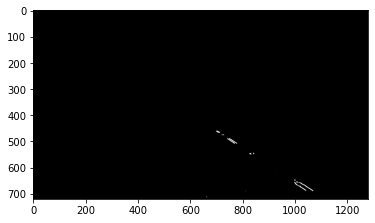

In [14]:
region_2 = np.array([[(640,720) , (1200,720) , (770,mask_top_cordinate),(640,mask_top_cordinate)]])
show_mask_region(Abs_Sob_Bit_Thr_x, region_2)

### 3.3 Get Source and Target Points

In [15]:
left_down, left_up = Get_Source_Points(Abs_Sob_Bit_Thr_x, region_1, mask_top_cordinate)
right_down, right_up = Get_Source_Points(Abs_Sob_Bit_Thr_x, region_2, mask_top_cordinate)

src = np.float32([left_up, right_up, right_down, left_down, ])
dst = np.float32([ [ left_down[0]+100 ,0 ],[ right_down[0]-100,0],
                  [right_down[0]-100, right_down[1]], [left_down[0]+100,left_down[1]] ])

### 3.4 Calculate Transfer Matrix


In [16]:
M = cv2.getPerspectiveTransform(src, dst)

Inv_M = cv2.getPerspectiveTransform(dst, src)

#### 3.4.1  Perspective Transformation Test

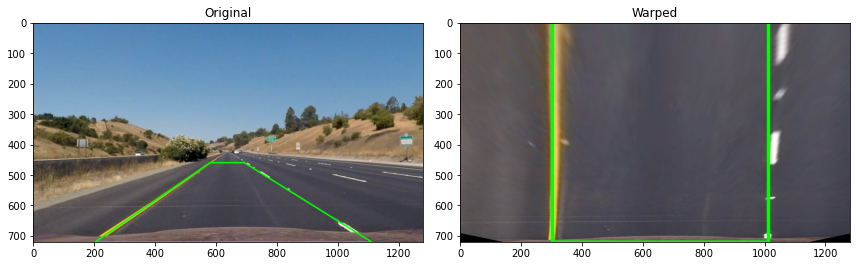

In [17]:
"""Draw Polygon on original image"""
polygon_ori = np.array([[left_down,right_down, right_up, left_up]])
img_copy = np.copy(image)
Ori_with_poly = cv2.polylines(img_copy,[polygon_ori],True,(0,255,0),3)

"""Transorm image and draw polygon """
polygon_perp = np.array([[ [ left_down[0]+100 ,0 ],[ right_down[0]-100,0],
                          [right_down[0]-100, right_down[1]], [left_down[0]+100,left_down[1]]]])
img_copy_2 = np.copy(image)
warped = cv2.warpPerspective(img_copy_2, M, (img_copy_2.shape[1],img_copy_2.shape[0]))
warped_with_poly = cv2.polylines(warped,[polygon_perp],True,(0,255,0),9)

"""Show  Images"""
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(Ori_with_poly, )
ax1.set_title('Original')
ax2.imshow(warped_with_poly)
ax2.set_title('Warped')    
plt.tight_layout()

## 4. Lane Detection

### 4.1 Process Raw Image

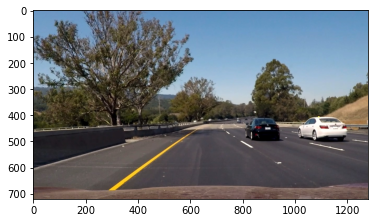

In [18]:
image = mpimg.imread("test_images/test6.jpg")
plt.imshow(image)

In [19]:
def Raw_Binary_Image_process(image):
    
    """Applying sobel and color space and filtering"""
    raw_sobel_x, raw_sobel_y = Sobel_raw_x_y_output(image)
    Abs_Sob_Bit_Thr_x = Sobel_Absolute_Binary(raw_sobel_x, 30, 255)
    
    S_HLS_Space = S_Channel_Thresh(image)
    
    
    Combined_Binary = np.zeros_like(Abs_Sob_Bit_Thr_x)
    Combined_Binary[(Abs_Sob_Bit_Thr_x == 1) |(S_HLS_Space == 1)] = 1
    
    width = Combined_Binary.shape[1]
    height = Combined_Binary.shape[0]
    Warp_Binary = cv2.warpPerspective(Combined_Binary, M, (width,height))
    
    
    return Warp_Binary

#### 4.1.1 Test Function

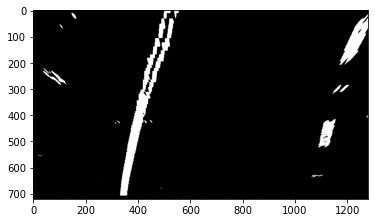

In [20]:
warp_binary = Raw_Binary_Image_process(image)
plt.imshow(warp_binary, cmap='gray')

### 4.2 Initialization Pixel Finding: Convolution Method

In [21]:
def Convolve_find_window_centroids(image, window_width = 80, window_height = 70, margin = 100):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
       
        if conv_signal[np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index] <= 100:
            l_center = l_center
        else:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        
        if conv_signal[np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index] <= 100:
            r_center = r_center
        else:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        #r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


#### 4.2.1 Convolution Test

In [22]:
window_centroids = Convolve_find_window_centroids(warp_binary)
for item in window_centroids:
    print(item)

(352.0, 1075.0)
(341.0, 1067.0)
(357.0, 1091.0)
(375.0, 1113.0)
(415.0, 1116.0)
(414.0, 1152.0)
(439.0, 1167.0)
(462.0, 1199.0)
(489.0, 1229.0)
(507.0, 1239.0)


#### 4.2.2 Convolution Window Visualization

In [23]:
def draw_window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def show_convoluton_windows(binary_image, window_width = 80, window_height = 70, margin = 100 ):
    window_centroids = Convolve_find_window_centroids(binary_image, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_image)
        r_points = np.zeros_like(binary_image)
        for level in range(0,len(window_centroids)):
            l_mask = draw_window_mask(window_width,
                    window_height,binary_image,window_centroids[level][0],level)
            r_mask = draw_window_mask(window_width,window_height,binary_image,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[ (l_mask == 1)  ] = 255
            r_points[ (r_mask == 1)  ] = 255
        
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((binary_image, binary_image, binary_image))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 0.5, template, 0.8, 0.0)
        
    plt.imshow(output)

#### 4.2.3 Output Visualization 

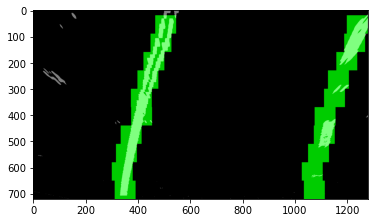

In [24]:
window_width = 80
window_height = 70
margin = 100
show_convoluton_windows(warp_binary, window_width, window_height, margin)


### 4.3 Mark Lane Pixels from Convolve method

In [25]:
def Color_and_Locate_Lane_Pixels(binary_image,window_centroids, window_width = 80, window_height = 70):
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    	
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
# Window_mask is a function to draw window areas
        win_y_low = binary_image.shape[0] - (level+1)*window_height
        win_y_high = binary_image.shape[0] - level*window_height
        
        win_xleft_low = max(0,int(window_centroids[level][0]-window_width/2))
        win_xleft_high = min(int(window_centroids[level][0]+window_width/2),binary_image.shape[1])
        win_xright_low = max(0,int(window_centroids[level][1]-window_width/2))
        win_xright_high = min(int(window_centroids[level][1]+window_width/2),binary_image.shape[1])
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    out_img_lane = np.dstack((binary_image, binary_image, binary_image))
    out_img_lane[lefty, leftx] = [255, 0, 0]
    out_img_lane[righty, rightx] = [0, 0, 255]
        
    return leftx ,lefty, rightx, righty, out_img_lane

#### 4.3.1 Output Visualization

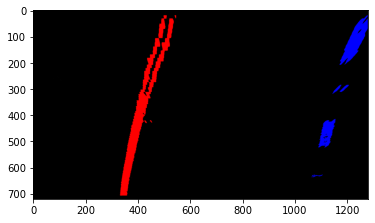

In [26]:
leftx ,lefty, rightx, righty, out_img_lane = \
Color_and_Locate_Lane_Pixels(warp_binary, window_centroids)

plt.imshow(out_img_lane)

### 4.4 Find Polynominal Coeff and Curve Rate

In [27]:
def Poly_Coeff_Draw(leftx, lefty, rightx, righty, RGB_image):    
    #Fit a second order polynomial to each using `np.polyfit`
    left_coeff = np.polyfit(lefty, leftx, 2)
    right_coeff = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploy_y_dots = np.linspace(0, RGB_image.shape[0]-1, RGB_image.shape[0] )
    left_poly_x_dots = left_coeff[0]*ploy_y_dots**2 + left_coeff[1]*ploy_y_dots + left_coeff[2]
    right_poly_x_dots = right_coeff[0]*ploy_y_dots**2 + right_coeff[1]*ploy_y_dots + right_coeff[2]
    """
    L_poly_start_point = left_poly_x_dots[RGB_image.shape[0]-1]
    R_poly_start_point = right_poly_x_dots[RGB_image.shape[0]-1]
    """
    Lane_Center = (left_poly_x_dots[RGB_image.shape[0]-1]+right_poly_x_dots[RGB_image.shape[0]-1])/2
    
    ym_per_pix =  30/720
    left_curverad = ((1 + (2*left_coeff[0]*(RGB_image.shape[0]-1)*ym_per_pix + left_coeff[1])**2)**1.5) \
                     / np.absolute(2*left_coeff[0])
    
    road_region_1 = np.array([np.transpose(np.vstack([left_poly_x_dots, ploy_y_dots]))])
    road_region_2 = np.array([np.flipud(np.transpose(np.vstack([right_poly_x_dots,ploy_y_dots])))])
    road_region_pts = np.hstack((road_region_1, road_region_2))
    
    road_region_img = np.zeros_like(RGB_image)
    cv2.fillPoly(road_region_img, np.int_([road_region_pts]), (0,255, 0))
    
    result_img = cv2.addWeighted(road_region_img, 0.3, RGB_image, 1, 0)
    
    
    return result_img, Lane_Center, left_curverad, left_coeff, right_coeff


#### 4.4.1 Output Visualization

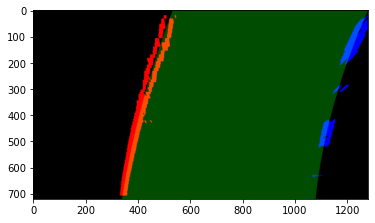

In [28]:
test_img, Lane_Center, Left_Curve, left_coeff, right_coeff = \
Poly_Coeff_Draw(leftx, lefty, rightx, righty, out_img_lane)

plt.imshow(test_img)

### 4.5 Mark Lane Pixels from Polynominal

In [29]:
def search_around_poly(binary_image, left_coeff, right_coeff, search_offset = 40):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    

    # Grab activated pixels
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_coeff[0]*(nonzeroy**2) + left_coeff[1]*nonzeroy + 
                    left_coeff[2] - search_offset)) & (nonzerox < (left_coeff[0]*(nonzeroy**2) + 
                    left_coeff[1]*nonzeroy + left_coeff[2] + search_offset)))
    right_lane_inds = ((nonzerox > (right_coeff[0]*(nonzeroy**2) + right_coeff[1]*nonzeroy + 
                    right_coeff[2] - search_offset)) & (nonzerox < (right_coeff[0]*(nonzeroy**2) + 
                    right_coeff[1]*nonzeroy + right_coeff[2] + search_offset)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img_lane = np.dstack((binary_image, binary_image, binary_image))
    out_img_lane[lefty, leftx] = [255, 0, 0]
    out_img_lane[righty, rightx] = [0, 0, 255]
    
    return leftx ,lefty, rightx, righty, out_img_lane

    

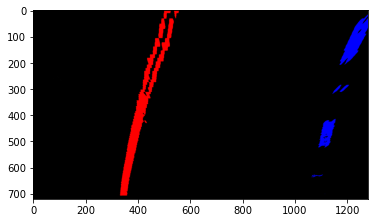

In [30]:
leftx ,lefty, rightx, righty, out_img_lane = \
search_around_poly(warp_binary, left_coeff, right_coeff, search_offset = 40)
plt.imshow(out_img_lane)

## 5. Unwarp and Add Lane Lines to Original Image

In [31]:
def Lane_Info_addon(raw_img, lane_warp_img, T_matrix, curve_rate, Lane_Center ):
    
    Unwarp_Road = cv2.warpPerspective(lane_warp_img, T_matrix, (raw_img.shape[1],raw_img.shape[0]))
    output = cv2.addWeighted(raw_img,  1, Unwarp_Road, 1, 0)
    
    font=cv2.FONT_HERSHEY_SIMPLEX  
    Add_Info=cv2.putText(output,'Curvature Rate: %d m' %curve_rate,(100,100),font,1.5,(0,0,0),5)
    xm_per_pix = 3.7/700
    distance_to_center = np.abs((Lane_Center - raw_img.shape[1]/2 )*xm_per_pix)
    if Lane_Center > int(raw_img.shape[1]/2):
        sign = "Left"
    else:
        sign = "Right"
        
    Add_Info=cv2.putText(Add_Info,'Vehicle is%6s %2.2f m to the center ' %(sign ,distance_to_center),(100,200),font,1.5,(0,0,0),5) 
    
    return output

In [32]:
output = Lane_Info_addon(image, test_img, Inv_M, Left_Curve, Lane_Center)

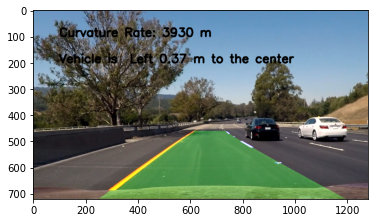

In [33]:
plt.imshow(output)

## 6. Pipeline

In [34]:
M = np.array([[-5.49273318e-01 , -1.52369228e+00 ,  9.92704483e+02],
 [ 0.00000000e+00 , -1.96259275e+00 ,  9.02792666e+02],
 [-4.33680869e-19 , -2.37321396e-03 ,  1.00000000e+00]])

Inv_M = np.array([[ 1.66908563e-01 , -7.71992563e-01 ,  5.31258345e+02],
  [ 1.99840144e-15 , -5.09530059e-01 ,  4.60000000e+02],
  [-8.67361738e-19 , -1.20922385e-03 ,  1.00000000e+00]])

In [35]:
glob.glob("test_images/*.jpg")

['test_images\\straight_lines1.jpg',
 'test_images\\straight_lines2.jpg',
 'test_images\\test1.jpg',
 'test_images\\test2.jpg',
 'test_images\\test3.jpg',
 'test_images\\test4.jpg',
 'test_images\\test5.jpg',
 'test_images\\test6.jpg']

In [36]:
def process_image(image ,left_coeff, right_coeff ):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    warp_binary = Raw_Binary_Image_process(image)
    
    if (len(left_coeff) == 0 and len(right_coeff)==0):
        window_center = Convolve_find_window_centroids(warp_binary)
        leftx ,lefty, rightx, righty, out_img_lane = \
        Color_and_Locate_Lane_Pixels(warp_binary,window_center)
        print("convolution")
    else:
        leftx ,lefty, rightx, righty, out_img_lane = \
        search_around_poly(warp_binary, left_coeff, right_coeff)
        print("Search round Poly")
        
    poly_img, Lane_Center, Left_Curve, left_coeff, right_coeff = \
    Poly_Coeff_Draw(leftx, lefty, rightx, righty, out_img_lane)
    
    
    output = Lane_Info_addon(image, poly_img, Inv_M, Left_Curve, Lane_Center )
    #print(Lane_Center)
    
    return output , left_coeff, right_coeff

In [37]:
left_coeff = []
right_coeff = []

convolution


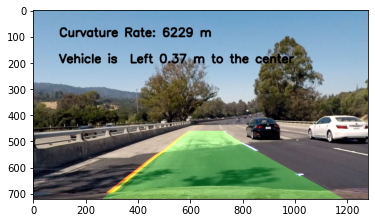

In [38]:
image = mpimg.imread("test_images/test4.jpg")
output,left_coeff, right_coeff = process_image(image,left_coeff, right_coeff)
plt.imshow(output)

# 7. Video Process

In [ ]:
cap = cv2.VideoCapture('challenge_video.mp4')

fourcc = cv2.VideoWriter_fourcc(*'XVID')

out = cv2.VideoWriter('output_Test_for_Fun.mp4', fourcc, 25.0, (1280, 720))


left_coeff = []
right_coeff = []

#while(a<50):
while(cap.isOpened()):
    
    ret, frame = cap.read()
    if ret == True:       
        
        output,left_coeff, right_coeff = process_image(frame,left_coeff, right_coeff)        
        out.write(output) 
    else:
        break  
    

cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
out.release()
cv2.destroyAllWindows()
